In [ ]:
pip install geopandas matplotlib shapely contextily


In [4]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import glob
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from shapely.affinity import translate
from shapely.geometry import box
from PIL import Image, ImageDraw
import matplotlib.colors as mcolors
import numpy as np

### Carga y Unificación de Rutas Geográficas y Límites Administrativos desde CSV y Shapefiles

In [ ]:
# ----------------------------------------
# 1. Leer y unir los CSVs con rutas (por CCAA)
# ----------------------------------------

csv_files = glob.glob("../../1. Obtención Y Procesado de Datos/Rutas/Rutas_Raw/*.csv")
rutas_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df["geometry"] = df["geometry"].apply(wkt.loads)
    rutas_list.append(gpd.GeoDataFrame(df, geometry="geometry"))

rutas_gdf = pd.concat(rutas_list, ignore_index=True)
rutas_gdf = gpd.GeoDataFrame(rutas_gdf, geometry="geometry", crs="EPSG:4326")

In [ ]:
# ----------------------------------------
# 2. Cargar y unir shapefiles (provincias y CCAA)
# ----------------------------------------

# Provincias
prov_pen = gpd.read_file("../../1. Obtención Y Procesado de Datos/1. Obtención Y Procesado de Datos/Ubicaciones y media/Mallas/Mallas_Prov/Malla_Peninsula/se89_10_admin_prov_a_x.shp")
prov_can = gpd.read_file("../../1. Obtención Y Procesado de Datos/1. Obtención Y Procesado de Datos/Ubicaciones y media/Mallas/Mallas_Prov/Malla_Canarias/se89_10_admin_prov_a_y.shp")
provincias = pd.concat([prov_pen, prov_can], ignore_index=True).to_crs("EPSG:4326")

# CCAA
ccaa_pen = gpd.read_file("../../1. Obtención Y Procesado de Datos/1. Obtención Y Procesado de Datos/Ubicaciones y media/Mallas/Mallas_CCAA/Malla_Peninsula/se89_10_admin_ccaa_a_x.shp")
ccaa_can = gpd.read_file("../../1. Obtención Y Procesado de Datos/1. Obtención Y Procesado de Datos/Ubicaciones y media/Mallas/Mallas_CCAA/Malla_Canarias/se89_10_admin_ccaa_a_y.shp")
ccaa = pd.concat([ccaa_pen, ccaa_can], ignore_index=True).to_crs("EPSG:4326")

### Generación de Mapas Coropléticos con Burbujas para Visualizar Rutas por Comunidad Autónoma o Provincia

In [ ]:
def generar_mapa(zonas_gdf, rutas_gdf, nombre_zona, titulo, output_file, escala_burbujas):
    # Unión espacial: asignar rutas a zonas
    join = gpd.sjoin(rutas_gdf, zonas_gdf, how="left", predicate="intersects")
    conteo = join.groupby(nombre_zona).size().reset_index(name="num_rutas")
    zonas = zonas_gdf.merge(conteo, on=nombre_zona, how="left").fillna(0)

    # Reproyectar a Web Mercator
    zonas = zonas.to_crs(epsg=3857)
    rutas_proj = rutas_gdf.to_crs(epsg=3857)
    zonas["centroide"] = zonas.geometry.centroid

    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 12))

    # Solo dibujamos los bordes de las zonas (opcional)
    zonas.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.5)

    # Crear un colormap de verde más equilibrado (verde medio a verde más oscuro)
    cmap = mcolors.ListedColormap(["#66bb6a", "#2c6b3f"])  # Verde medio a verde más oscuro
    norm = mcolors.Normalize(vmin=zonas["num_rutas"].min(), vmax=zonas["num_rutas"].max())  # Normaliza según el rango de rutas


    # Dibujar burbujas
    for _, row in zonas.iterrows():
        x, y = row["centroide"].x, row["centroide"].y
        num_rutas = int(row["num_rutas"])  # Obtener el número de rutas
        size = num_rutas * escala_burbujas  # Tamaño de la burbuja

        # Asignar color según el número de rutas
        color = cmap(norm(num_rutas))  # El color de la burbuja según el número de rutas
        
        # Dibujar burbuja
        ax.scatter(x, y, s=size, color=color, alpha=0.5, linewidths=0.5)

        # Solo añadir número dentro de la burbuja si hay más de 0 rutas
        if num_rutas > 0:
            ax.text(x, y, str(num_rutas), fontsize=9, ha="center", va="center", color="#333333")

    # Añadir mapa base completo con etiquetas y ciudades usando OpenStreetMap (mayor resolución)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

    # Título del mapa
    ax.set_title(titulo, fontsize=16)
    ax.axis("off")

    # Guardar el mapa como imagen
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Mapa guardado en {output_file}")





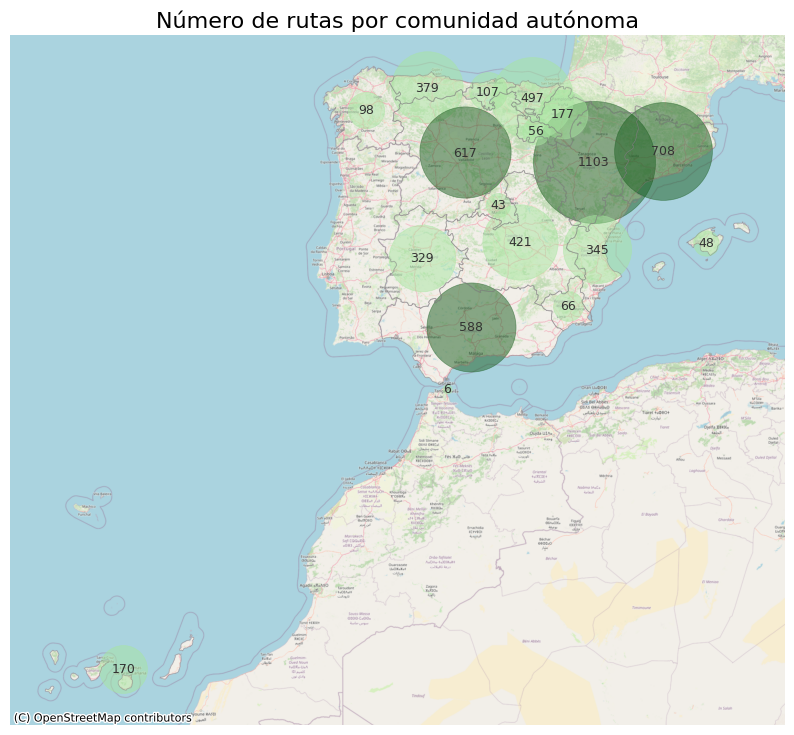

Mapa guardado en mapa_rutas_ccaa.png


' # Mapa por provincias\ngenerar_mapa(\n    zonas_gdf=provincias,\n    rutas_gdf=rutas_gdf,\n    nombre_zona="rotulo",\n    titulo="Número de rutas por provincia",\n    output_file="mapa_rutas_provincias.png",\n    escala_burbujas=7\n) '

In [16]:
# ----------------------------------------
# 4. Generar los dos mapas
# ----------------------------------------

# Mapa por comunidades
generar_mapa(
    zonas_gdf=ccaa,
    rutas_gdf=rutas_gdf,
    nombre_zona="rotulo",
    titulo="Número de rutas por comunidad autónoma",
    output_file="mapa_rutas_ccaa.png",
    escala_burbujas=7
)

""" # Mapa por provincias
generar_mapa(
    zonas_gdf=provincias,
    rutas_gdf=rutas_gdf,
    nombre_zona="rotulo",
    titulo="Número de rutas por provincia",
    output_file="mapa_rutas_provincias.png",
    escala_burbujas=7
) """




In [67]:
print(dir(ctx.providers))

['AzureMaps', 'BaseMapDE', 'BasemapAT', 'CartoDB', 'CyclOSM', 'Esri', 'FreeMapSK', 'Gaode', 'GeoportailFrance', 'HERE', 'HEREv3', 'HikeBike', 'Jawg', 'JusticeMap', 'MapBox', 'MapTiler', 'MapTilesAPI', 'MtbMap', 'NASAGIBS', 'NLS', 'OPNVKarte', 'OneMapSG', 'OpenAIP', 'OpenFireMap', 'OpenRailwayMap', 'OpenSeaMap', 'OpenSnowMap', 'OpenStreetMap', 'OpenTopoMap', 'OpenWeatherMap', 'OrdnanceSurvey', 'SafeCast', 'Stadia', 'Strava', 'SwissFederalGeoportal', 'Thunderforest', 'TomTom', 'TopPlusOpen', 'USGS', 'WaymarkedTrails', 'nlmaps']
